In [15]:
## Download data

suppressMessages(library(tidyverse))
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
suppressMessages(library(ggridges))


## Download Illumina data
df_mcnv3_illum <- read_csv("../data/Illumina_nofilter_mCNVs.csv")
if(colnames(df_mcnv3_illum)[2] == "COMPUTED_GENDER"){
  colnames(df_mcnv3_illum)[2] = "SEX"
}## Download Affy data

df_mcnv3_affy <- read_csv("..//data/Affy6_nofilter_mCNVs.csv")

if(colnames(df_mcnv3_affy)[2] == "COMPUTED_GENDER"){
  colnames(df_mcnv3_affy)[2] = "SEX"
}


## Merge
df_mcnv3 = rbind(df_mcnv3_illum %>% dplyr::select(-c(CALL_RATE)), df_mcnv3_affy)





── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  SAMPLE = col_character(),
  COMPUTED_GENDER = col_character(),
  CHROM = col_character(),
  P_ARM = col_character(),
  Q_ARM = col_character(),
  TYPE = col_character(),
  batch = col_character(),
  arrayName = col_character(),
  identifier = col_character(),
  RETYPE = col_character(),
  label = col_character(),
  CALL_RATE = col_logical(),
  CYTOBAND = col_character(),
  GENES = col_character()
)
ℹ Use `spec()` for the full column specifications.


Warning message:
“6071 parsing failures.
  row       col           expected actual                                  file
21982 CALL_RATE 1/0/T/F/TRUE/FALSE 0.9994 '../data/Illumina_nofilter_mCNVs.csv'
21983 CALL_RATE 1/0/T/F/TRUE/FALSE 0.9995 '../data/Illumina_nofilter_mCNVs.csv'
21984 CALL_RATE 1/0/T/F/TRUE/FALSE 0.9999 '../data/Illumina_nofilter_mCNVs.csv'
21985 CALL_RATE 1/0/T/F/TRU

In [16]:
## Filtering 

nhets=20
overlap_control = 0.50
overlap_1kg = 0.50
overlap_pgc = 0.50
baf_cutoff = 0.10


df_mosaic0 <- df_mcnv3 %>% mutate(CHROM = trimws(CHROM)) %>%
  filter(CHROM != "X") %>%
  mutate(batch = str_replace(string=.$batch,pattern="_1|_3",replacement = "")) %>% 
  mutate(batch = str_replace(string=.$batch,pattern="_eur-qc",replacement = "")) %>%
  filter(OVRLP_CONTROL < overlap_control) %>% 
  filter(!(OVRLP_PGC > overlap_pgc & RETYPE == "DUP")) %>%
  filter(!(RETYPE == "DUP" & BDEV > baf_cutoff)) %>% 
  filter(label != "non-SCZ")  %>% mutate(low_qual = (LOD_BAF_PHASE < 10)) %>% filter(!low_qual) %>% filter(RETYPE!="UKN")
# %>% filter(Posterior > 0.95)

compute_CF <- function(BDEV, TYPE){
  ## Function to impute CF
  if (TYPE == "DUP"){
    CF = 2*BDEV/(0.5 - BDEV)
  } else if (TYPE== "DEL"){
    CF = 2*BDEV/(0.5 + BDEV)
  } else if (TYPE == "CNN-LOH"){
    CF = 2*BDEV
  } else{
    return("Type needs to be DUP, DEL, or CN-LOH")
  }
  return(CF)
}

for (i in 1:nrow(df_mosaic0)){
  if(is.na(df_mosaic0$CF[i])){
    df_mosaic0$CF[i] = compute_CF(df_mosaic0$BDEV[i], df_mosaic0$RETYPE[i])
  }
}

## FIltering out residual germline events
df_mosaic0 <- df_mosaic0 %>% filter(!(CHROM == "7" & BEG_GRCh37 == 0 & END_GRCh37 == 68920) &  
                        !(CHROM == "20" & BEG_GRCh37 == 59569516 & END_GRCh37 == 59589272))

df_mosaic0 = df_mosaic0 %>% filter(!(RETYPE=="DEL" & LDEV < -0.5 & arrayName == "Affy6"))
df_mosaic0 = df_mosaic0 %>% filter(!(batch %in% c("GAIN","Gejman.MGS","scz_lacw_lemu_eur_qc"))) ## these batches were come cell lines. 

df_mosaic = df_mosaic0 %>% filter( !(CHROM == "6" & BEG_GRCh37 > 1.9e7 & END_GRCh37 < 5e7) &
                                     !(CHROM == "14" & BEG_GRCh37 >105e6 & END_GRCh37 <108e6) &
                                     !(CHROM == "22" & BEG_GRCh37 > 2.2e7 & END_GRCh37 < 2.4e7) ) %>% filter(FailedQC ==0)


In [17]:
## Further filter potential clonal hematopoesis artifact

## this block produces the final filtered callset
df_mosaic_ <- df_mosaic %>% filter(CF < 1)

## Filter common events in UKBB
df_mosaic_ = df_mosaic_ %>% filter(!(grepl("20q11",CYTOBAND) & RETYPE =="DEL")) %>%
  filter(!(grepl("DNMT3A|DNMT3A,|,DNMT3A",GENES) & RETYPE=="DEL")) %>%
  filter(!(grepl(",TET2|,TET2",GENES) & RETYPE == "DEL")) %>% 
  filter(!(grepl("^13q14", CYTOBAND) & RETYPE == "DEL")) %>% 
  filter(!(grepl("17p", CYTOBAND) & RETYPE =="DEL")) %>%
  filter(!(grepl("^5q14", CYTOBAND) & RETYPE =="DEL")) %>%
  filter(!(grepl(",ATM|ATM,", GENES) & RETYPE =="DEL")) %>%
  filter(!(grepl("15q", CYTOBAND) & RETYPE == "DUP")) %>%
  filter(RETYPE != "CNN-LOH" ) %>% filter(!(grepl("7q34", CYTOBAND))) %>% filter(!(grepl("14q11.2", CYTOBAND))) %>%
  filter(!(CHROM== "12" & P_ARM == "T" & Q_ARM == "T"))

many_calls = df_mosaic_ %>% group_by(SAMPLE) %>% summarise(n=n())  %>% filter(n > 5)
df_mosaic_ <- df_mosaic_ %>%  filter(!(SAMPLE %in% many_calls$SAMPLE)) 

write.csv(df_mosaic_, file="../data/COMBINED_filtered_sCNV.csv",row.names=FALSE)


In [18]:
nrow(df_mosaic_)

[1] 198

### Figure 1B

Joining, by = c("SAMPLE", "SEX", "CHROM", "BEG_GRCh37", "END_GRCh37", "LENGTH", "P_ARM", "Q_ARM", "N_SITES", "NHETS", "N50_HETS", "BDEV", "BDEV_SE", "REL_COV", "REL_COV_SE", "LOD_LRR_BAF", "LOD_BAF_PHASE", "N_FLIPS", "BAF_CONC", "LOD_BAF_CONC", "TYPE", "CF", "batch", "arrayName", "FailedQC", "SAMPLE_BAF_SD", "LDEV", "LRR_SD", "BAF_AUTO", "SAMPLE_MULTICALL", "SAMPLE_BAF_SD_FLAG", "OVRLP_1KG", "identifier", "OVRLP_PGC", "OVRLP_CONTROL", "p_DUP", "p_LOH", "p_DEL", "Posterior", "RETYPE", "label", "CYTOBAND", "GENES", "number_genes", "log_number_genes", "high_pLI_genes", "brain_genes", "synaptic_genes", "abc_genes")



[1] 1143

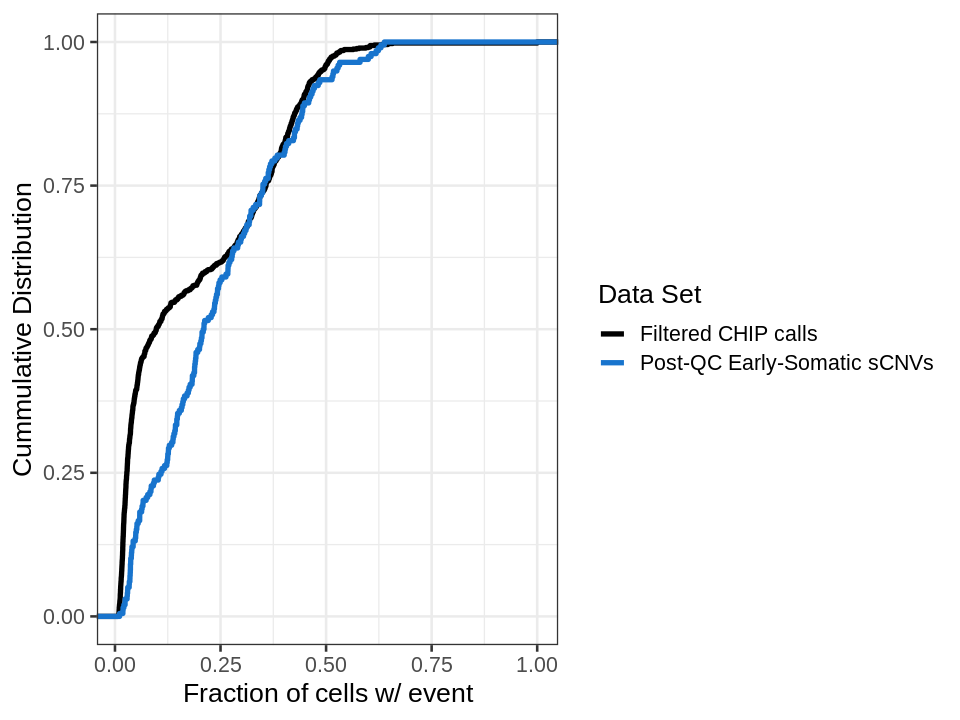

In [19]:
df_tmp = df_mosaic_ %>% dplyr::select(-c("low_qual"))
df_chip = anti_join(df_mosaic0, df_tmp)

## number of events filtered as chip
nrow(df_chip)

df_combined <- data.frame(cell_fraction = c(df_chip$CF, df_mosaic_$CF),
                          data_set = c(rep("CHIP",nrow(df_chip)), rep("early-developmental",nrow(df_mosaic_))))


options(repr.plot.width=8, repr.plot.height=6)
df_combined %>% ggplot(aes(cell_fraction, color=data_set)) + stat_ecdf(geom="step",lwd=1.5) +
  theme_bw(base_size = 16) + labs(x="Fraction of cells w/ event", y = "Cummulative Distribution", color="Data Set") + scale_color_manual(values=c("black","dodgerblue3"),labels=c("Filtered CHIP calls","Post-QC Early-Somatic sCNVs")) 

### Figure 1C

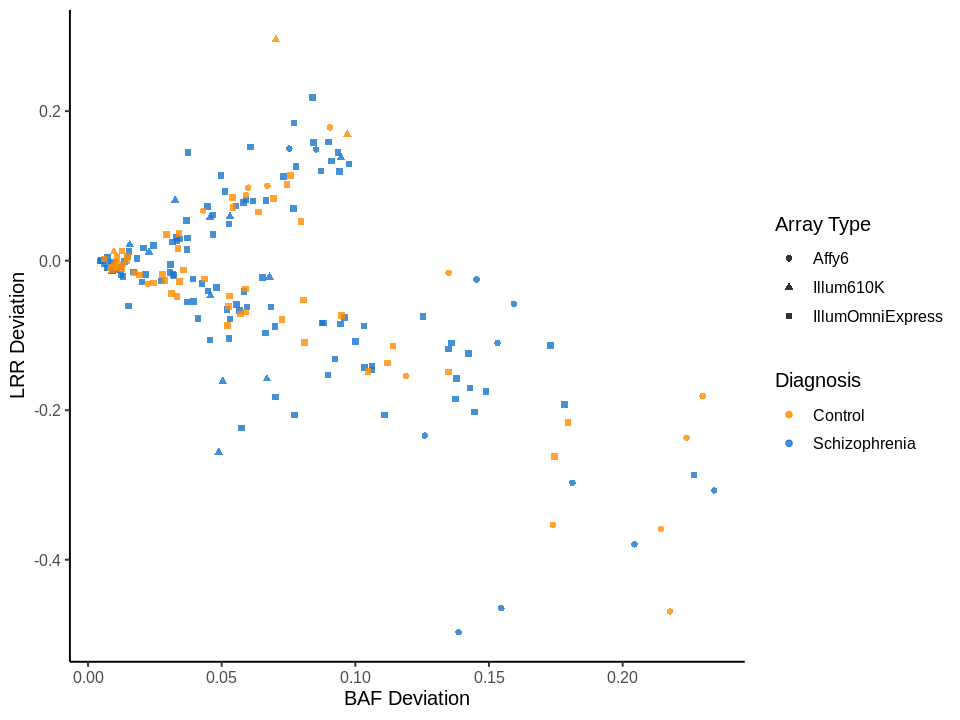

In [5]:

df_mosaic_ %>% ggplot(aes(x = BDEV, y = LDEV)) + 
    geom_point(aes(color=label, shape=arrayName), alpha=0.8) + 
    theme_classic(base_size=12) + 
    scale_color_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) + 
    labs(shape="Array Type", color="Diagnosis", y = "LRR Deviation",x="BAF Deviation") 


In [6]:
## This block also calculates the sample size for cases and controls

stats_df_affy = read_csv("../data/metadata/Affy6_stats_2021-02-09.csv")
stats_df_illum = read_csv("../data/metadata/Illumina_stats_2021-07-28.csv")

stats_df <- rbind(stats_df_illum, stats_df_affy %>% dplyr::select(-c("Age", "ancestry")))

mut_count <- data.frame(table(df_mosaic_$SAMPLE)) 
rownames(mut_count) <- mut_count$Var1
stats_df <- stats_df %>% mutate(post_QC_sCNVs= mut_count[match(SAMPLE, mut_count$Var1),"Freq"])
stats_df$post_QC_sCNVs[is.na(stats_df$post_QC_sCNVs)] = 0


stats_filtered = stats_df %>% filter(stats_df$CALL_RATE > 0.97 & BAF_CONC < 0.51 & BAF_AUTO < 0.03 & FailedQC == 0) %>% filter(!(batch %in% c("GAIN","Gejman.MGS","scz_lacw_lemu_eur_qc")))

stats_filtered$batch[stats_filtered$batch == "E26"] = "scz_egcu"
stats_filtered$batch[stats_filtered$batch == "OmniTE"] = "scz_egcu"

n_dx = sum(stats_filtered$diagnosis == "SCZ")
n_ctrl = sum(stats_filtered$diagnosis == "CONT")



## Total samples processesed
with(stats_df %>% filter(!(batch %in% c("GAIN","Gejman.MGS","scz_lacw_lemu_eur_qc"))), table(diagnosis))
# SCZ 13,464 and CONT 12,722
13464 + 12722

## Total samples kept
with(stats_filtered, table(diagnosis))
# SCZ 12,834 and CONT 11,648
12834 + 11648



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  SAMPLE = col_character(),
  COMPUTED_GENDER = col_character(),
  Y_NONPAR_LRR_MEDIAN = col_logical(),
  MT_LRR_MEDIAN = col_logical(),
  batch = col_character(),
  diagnosis = col_character(),
  arrayType = col_character(),
  ancestry = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  SAMPLE = col_character(),
  COMPUTED_GENDER = col_character(),
  Y_NONPAR_LRR_MEDIAN = col_logical(),
  MT_LRR_MEDIAN = col_logical(),
  batch = col_character(),
  FailedQC = col_logical(),
  diagnosis = col_character(),
  arrayType = col_character()
)
ℹ Use `spec()` for the full column specifications.




diagnosis
                                          CONT 
                                         12722 
                                      Excluded 
                                           125 
                                       Missing 
                                             2 
                                  Non.SCZ.CASE 
                                           886 
                                      Prodrome 
                                            38 
                                 Psychosis NOS 
                                             1 
Psychosis with borderline personality disorder 
                                             1 
                                           SCZ 
                                         13464 

[1] 26186

diagnosis
                                          CONT 
                                         11648 
                                      Excluded 
                                           121 
                                       Missing 
                                             1 
                                  Non.SCZ.CASE 
                                           838 
                                      Prodrome 
                                            36 
                                 Psychosis NOS 
                                             1 
Psychosis with borderline personality disorder 
                                             1 
                                           SCZ 
                                         12834 

[1] 24482

In [7]:
## Characterization of mutations

## number of events
nrow(df_mosaic_)

## number of individuals with mutations
length(unique(df_mosaic_$SAMPLE))

## sCNV types
with(df_mosaic_, table(RETYPE))

## Range and median size
range(df_mosaic_$LENGTH)
median(df_mosaic_$LENGTH)

## Range and median CF
range(df_mosaic_$CF)
median(df_mosaic_$CF)


## Sex differences
with(df_mosaic_, table(label, SEX))
fisher.test(with(df_mosaic_, table(label, SEX)))

[1] 198

[1] 178

RETYPE
DEL DUP 
128  70 

[1]    10663 95252002

[1] 688574.5

[1] 0.0109 0.6380

[1] 0.2099356

      SEX
label   F  M
  ctrl 29 38
  SCZ  46 85


	Fisher's Exact Test for Count Data

data:  with(df_mosaic_, table(label, SEX))
p-value = 0.2813
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.7366846 2.6836194
sample estimates:
odds ratio 
  1.407654 


### Supplemental Figure 1A

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Warning message:
“Removed 1 rows containing missing values (geom_segment).”


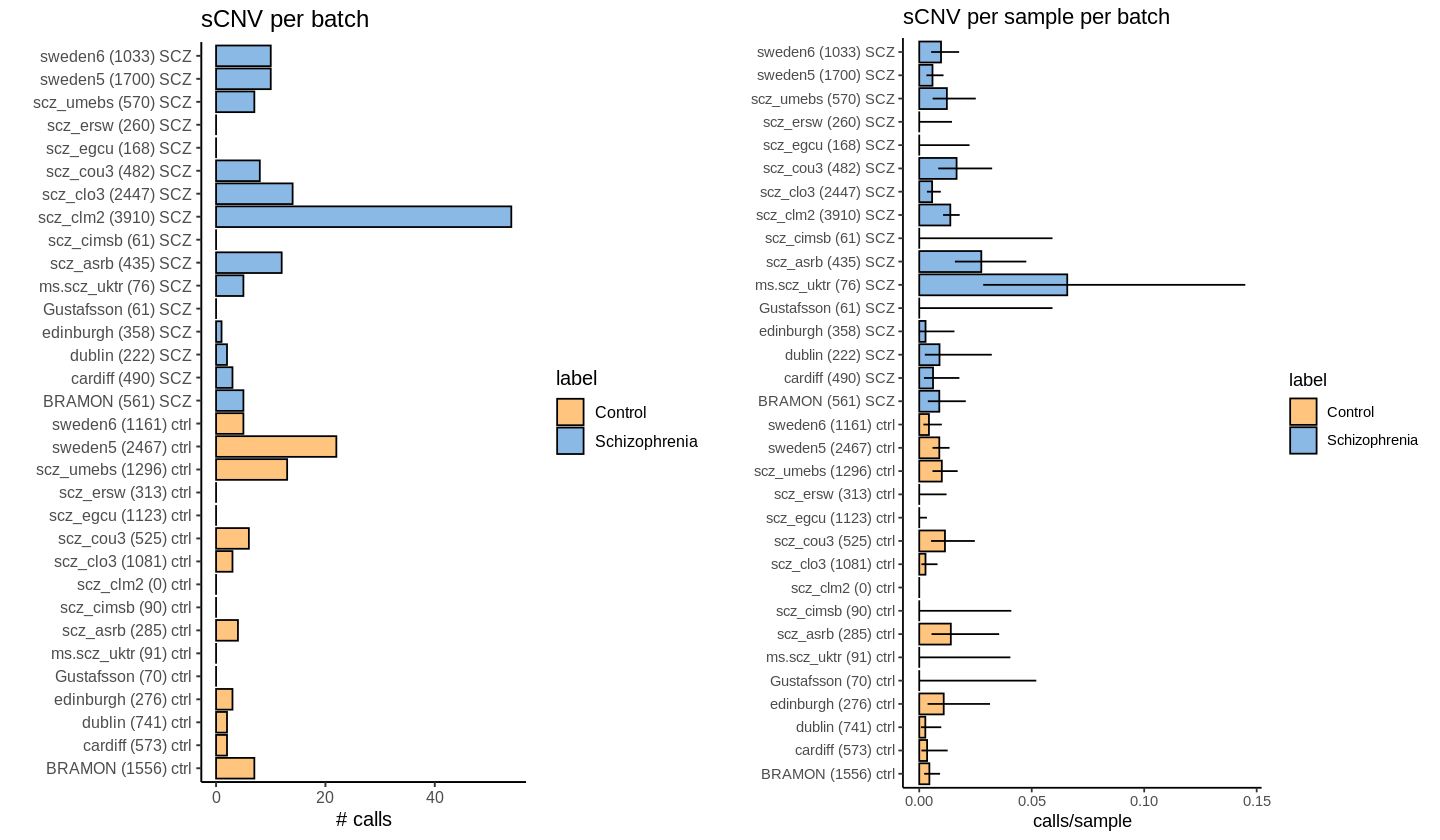

In [8]:
library(ggpubr)
stats_filtered = stats_filtered %>% mutate(batch = str_replace(string=.$batch,pattern="_1|_3",replacement = "")) %>% 
mutate(batch = str_replace(string=.$batch,pattern="_eur-qc",replacement = ""))
batch_numbers = table(stats_filtered$batch, stats_filtered$diagnosis)


muts_perBatch = expand_grid(batch=unique(stats_filtered$batch),label=c("ctrl","SCZ"))
muts_perBatch$sample_size = 0
muts_perBatch$sample_size[which(muts_perBatch$label == "SCZ")] = batch_numbers[muts_perBatch$batch[which(muts_perBatch$label == "SCZ")], "SCZ"]
muts_perBatch$sample_size[which(muts_perBatch$label == "ctrl")] = batch_numbers[muts_perBatch$batch[which(muts_perBatch$label == "ctrl")], "CONT"]

## Remove batches that have no samples after QC
muts_perBatch = muts_perBatch %>% filter(!(batch %in% c("Vanderbilt_Australian","Vanderbilt_Biobank","Vanderbilt_Irirsh","Positive_Controls", "Vanderbilt_Irish")))

muts_perBatch$sCNVs = 0
muts_perBatch$sCNVs[which(muts_perBatch$label == "SCZ")] = df_mosaic_ %>%  filter(label=="SCZ") %>% group_by(batch) %>% 
  summarise(sCNVs = n()) %>% ungroup() %>% as_tibble() %>% tibble::column_to_rownames(var="batch") %>%
  .[muts_perBatch$batch[which(muts_perBatch$label == "SCZ")],]
muts_perBatch$sCNVs[which(muts_perBatch$label == "ctrl")] = df_mosaic_ %>% filter(label=="ctrl") %>% group_by(batch) %>% 
  summarise(sCNVs = n()) %>% ungroup() %>% as_tibble () %>% tibble::column_to_rownames(var="batch") %>%
  .[muts_perBatch$batch[which(muts_perBatch$label == "ctrl")],]

muts_perBatch[is.na(muts_perBatch)] = 0

library(forcats)
library(Hmisc)

p1 = muts_perBatch %>% mutate(my_label = paste0(batch," (",sample_size,") ", label)) %>% ggplot(aes(y=fct_reorder(my_label,label), x=sCNVs)) + 
  geom_bar(aes(fill = label), alpha = 0.5,color="black",stat="identity", position = position_dodge2(preserve="single")) + theme_classic(base_size=12) + 
  labs(y="",x="# calls", title="sCNV per batch") +
  scale_fill_manual(values=c("darkorange","dodgerblue3"),label=c("Control","Schizophrenia"))


p2= muts_perBatch %>% mutate(my_label = paste0(batch," (",sample_size,") ", label)) %>% mutate(rate= sCNVs/sample_size, ci = sqrt(rate*(1-rate)/sample_size)) %>% mutate_if(is.numeric, replace_na, 0) %>% 
  mutate(ciupper= binconf(sCNVs, sample_size, method="wilson", return.df=TRUE)$Upper, 
          cilower = binconf(sCNVs, sample_size, method="wilson", return.df=TRUE)$Lower,) %>%
  ggplot(aes(y=fct_reorder(my_label,label), x=rate)) + geom_bar(aes(fill = label),alpha= 0.5,color="black", stat="identity", position = position_dodge2(preserve="single")) + theme_classic(base_size=11) + labs(y="",x="calls/sample", title="sCNV per sample per batch") + geom_linerange(aes(xmin = cilower, xmax= ciupper)) +
  scale_fill_manual(values=c("darkorange","dodgerblue3"),label=c("Control","Schizophrenia"))


options(repr.plot.width=12, repr.plot.height=7)
g3 = ggarrange(p1,p2,ncol=2)
g3


In [9]:
## Perform Fisher's exact test per batch on the samples that have both case and control samples. 
stats_filtered2 = stats_filtered
stats_filtered2$batch[(stats_filtered2$batch == "scz_clm2") | (stats_filtered2$batch == "scz_clo3")] = "CLOZUK"
stats_filtered2 = stats_filtered2 %>% mutate(batch = str_replace(string=.$batch,pattern="_1|_3",replacement = "")) %>% 
mutate(batch = str_replace(string=.$batch,pattern="_eur-qc",replacement = ""))
batch_numbers = table(stats_filtered2$batch, stats_filtered2$diagnosis)


muts_perBatch = expand_grid(batch=unique(stats_filtered2$batch),label=c("ctrl","SCZ"))
muts_perBatch$sample_size = 0
muts_perBatch$sample_size[which(muts_perBatch$label == "SCZ")] = batch_numbers[muts_perBatch$batch[which(muts_perBatch$label == "SCZ")], "SCZ"]
muts_perBatch$sample_size[which(muts_perBatch$label == "ctrl")] = batch_numbers[muts_perBatch$batch[which(muts_perBatch$label == "ctrl")], "CONT"]

## Remove batches that have no samples after QC
muts_perBatch = muts_perBatch %>% filter(!(batch %in% c("Vanderbilt_Australian","Vanderbilt_Biobank","Vanderbilt_Irirsh","Positive_Controls", "Vanderbilt_Irish")))

muts_perBatch$sCNVs = 0
df_mosaic_2 = df_mosaic_
df_mosaic_2$batch[(df_mosaic_2$batch =="scz_clm2") | (df_mosaic_2$batch == "scz_clo3")] = "CLOZUK"
muts_perBatch$sCNVs[which(muts_perBatch$label == "SCZ")] = df_mosaic_2 %>%  filter(label=="SCZ") %>% group_by(batch) %>% 
  summarise(sCNVs = n()) %>% ungroup() %>% as_tibble() %>% tibble::column_to_rownames(var="batch") %>%
  .[muts_perBatch$batch[which(muts_perBatch$label == "SCZ")],]
muts_perBatch$sCNVs[which(muts_perBatch$label == "ctrl")] = df_mosaic_2 %>% filter(label=="ctrl") %>% group_by(batch) %>% 
  summarise(sCNVs = n()) %>% ungroup() %>% as_tibble () %>% tibble::column_to_rownames(var="batch") %>%
  .[muts_perBatch$batch[which(muts_perBatch$label == "ctrl")],]

muts_perBatch[is.na(muts_perBatch)] = 0

batch_pvals = c()
weights= c()
for(b in unique(muts_perBatch$batch)){
  tmp = muts_perBatch %>% filter(batch == b)
  if( tmp$sample_size[tmp$label == "ctrl"] > 0){
    if(tmp$sample_size[tmp$label =="SCZ"] > 0){
      dx_counts = tmp$sCNVs[tmp$label=="SCZ"]
      ctrl_counts = tmp$sCNVs[tmp$label=="ctrl"]
      dx_size = tmp$sample_size[tmp$label=="SCZ"]
      ctrl_size = tmp$sample_size[tmp$label=="ctrl"]
      tmp_pval = fisher.test(matrix(c(dx_counts, dx_size - dx_counts, ctrl_counts, ctrl_size - ctrl_counts), nc=2, byrow=TRUE),alternative="greater")
      batch_pvals = c(batch_pvals, tmp_pval$p.value)
      weights = c(weights, sqrt(dx_size+ctrl_size))
    }
  }
}



## Tippett's method
min(batch_pvals)

## Liptk's/ Stouffer's method
library(metap)
sumz(batch_pvals,weights=weights)


[1] 0.005105983


Attaching package: ‘metap’


The following object is masked from ‘package:Hmisc’:

    plotp


Warning message in sumz(batch_pvals, weights = weights):
“Some studies omitted”
Warning message in sumz(batch_pvals, weights = weights):
“Weights omitted too”


sumz =  1.98711 p =  0.02345512 

### Figure 1D

# A tibble: 10 x 7
   label burden burden_fraction cilower ciupper cf         pval
   <chr>  <int>           <dbl>   <dbl>   <dbl> <chr>     <dbl>
 1 ctrl      60         0.00515 0.00400 0.00662 > 0    0.000207
 2 SCZ      118         0.00919 0.00768 0.0110  > 0    0.000207
 3 ctrl      52         0.00446 0.00341 0.00585 > 0.05 0.000818
 4 SCZ      101         0.00787 0.00648 0.00955 > 0.05 0.000818
 5 ctrl      44         0.00378 0.00282 0.00507 > 0.1  0.000287
 6 SCZ       93         0.00725 0.00592 0.00887 > 0.1  0.000287
 7 ctrl      32         0.00275 0.00195 0.00388 > 0.2  0.00316 
 8 SCZ       66         0.00514 0.00404 0.00654 > 0.2  0.00316 
 9 ctrl      20         0.00172 0.00111 0.00265 > 0.3  0.0116  
10 SCZ       44         0.00343 0.00256 0.00460 > 0.3  0.0116  
# A tibble: 10 x 7
   label burden burden_fraction  cilower ciupper cf        pval
   <chr>  <int>           <dbl>    <dbl>   <dbl> <chr>    <dbl>
 1 ctrl      39         0.00335 0.00245  0.00457 > 0    0.00210
 2

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,60,0.005151099
SCZ,118,0.009194328



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_SCZ - df_counts_total$burden[2], df_counts_total$burden[1], n_CONT - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.0002069
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.301195 2.490666
sample estimates:
odds ratio 
  1.792161 


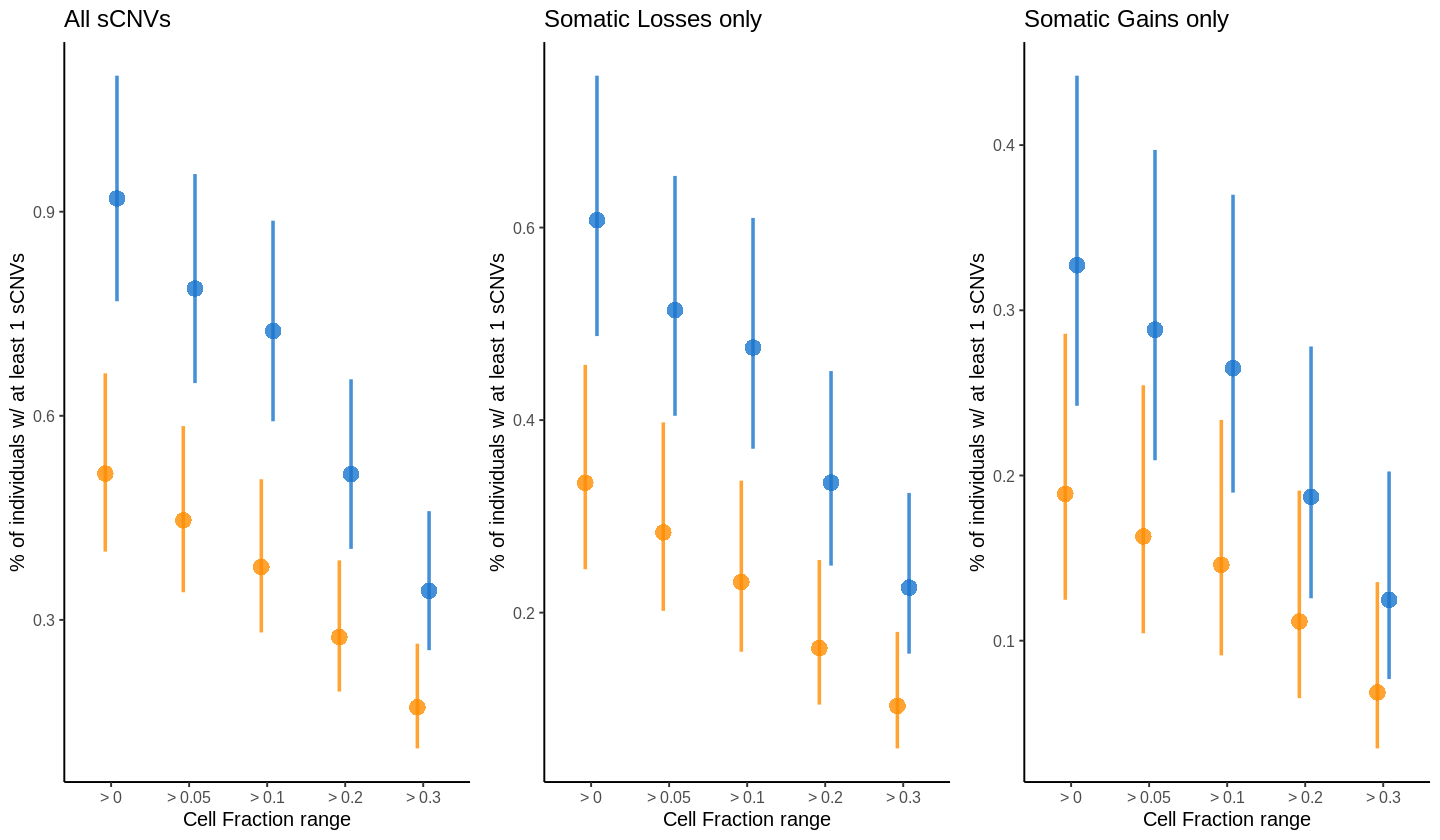

In [10]:
n_SCZ = n_dx
n_CONT = n_ctrl
library(Hmisc)

## Plot prelance across all events across different cell fractions

burden_plots <- function(mut_type,title){
  #cf_ranges = c(0,0.05,0.10,0.20,0.30,0.4,0.5)
  df_counts_plot <- data.frame()
  cf_ranges = c(0,0.05,0.10,0.20,0.30)
  for(i in 1:length(cf_ranges)){
    tmp <- df_mosaic_ %>% filter(CF > cf_ranges[i]) %>% filter(RETYPE %in% mut_type) %>% group_by(label) %>% arrange(desc(CF)) %>% distinct(SAMPLE,.keep_all = TRUE) %>% summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_CONT,n_SCZ), cilower = binconf(burden, c(n_CONT, n_SCZ), method="wilson", return.df=TRUE)$Lower, ciupper= binconf(burden, c(n_CONT, n_SCZ), method="wilson", return.df=TRUE)$Upper, cf=paste(">",cf_ranges[i]))
    
    pval = fisher.test(matrix(c(tmp$burden[2],n_SCZ-tmp$burden[2],tmp$burden[1],n_CONT-tmp$burden[1]), ncol=2, byrow = TRUE),alternative = "two.sided")$p.value
    tmp$pval = pval
    df_counts_plot = rbind(df_counts_plot, tmp)
  }
  
  print(df_counts_plot)
  
  p1 = df_counts_plot %>% mutate(burden_percent = 100*burden_fraction) %>% ggplot(aes(x=cf,y=burden_percent)) + 
    geom_pointrange(aes(color=label, ymax=100*ciupper, ymin=100*cilower), lwd=1, alpha=0.8,show.legend = FALSE,
                    position=position_dodge2(width=0.3),pch=16) + 
    theme_classic(base_size = 12) + 
    scale_color_manual(values=c("darkorange","dodgerblue3"),label=c("Control","Schizophrenia")) + 
    labs(x="", y= "% of individuals w/ at least 1 sCNVs",color="") + 
    scale_x_discrete(labels=c("ctrl"= "Control","SCZ"="Schizophrenia")) + 
    labs(x= "Cell Fraction range", title=title) 
  return(p1)
}

p1 = burden_plots(c("DEL","DUP"),title="All sCNVs")
p2 = burden_plots(c("DEL"), "Somatic Losses only")
p3 = burden_plots(c("DUP"), "Somatic Gains only")
p4 = ggarrange(p1,p2,p3, ncol=3)
p4

############################

## calculate overall burden and p-value

df_counts_total <- df_mosaic_  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_CONT,n_SCZ))
head(df_counts_total)

#df_counts_total %>% mutate(burden_percent = 100*burden_fraction, ci = 196*sqrt(burden_fraction*(1-burden_fraction)/c(n_CONT,n_SCZ))) %>% ggplot(aes(x=label,y=burden_percent)) + geom_pointrange(aes(color=label, ymax=burden_percent+ci, ymin=burden_percent-ci), lwd=1, alpha=0.5,show.legend = FALSE) + theme_classic(base_size = 12) + scale_color_manual(values=c("darkorange","dodgerblue3"),label=c("Control","Schizophrenia")) + labs(x="", y= "% of individuals w/ at least 1 sCNVs",color="") + scale_x_discrete(labels=c("ctrl"= "Control","SCZ"="Schizophrenia"))


fisher.test(matrix(c(df_counts_total$burden[2],n_SCZ-df_counts_total$burden[2],df_counts_total$burden[1],n_CONT-df_counts_total$burden[1]), ncol=2, byrow = TRUE),alternative = "two.sided")


### Figure 1E and Supplemental Figure 1B


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: isSCZ ~ log10(LENGTH) + SEX + (1 | batch)
   Data: df_mosaic_ %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>%  
    summarise(LENGTH = sum(LENGTH)) %>% ungroup()

     AIC      BIC   logLik deviance df.resid 
   190.6    203.3    -91.3    182.6      174 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3584 -0.7088  0.2596  0.6018  1.6932 

Random effects:
 Groups Name        Variance Std.Dev.
 batch  (Intercept) 1.135    1.066   
Number of obs: 178, groups:  batch, 11

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)     1.3706     1.3538   1.012    0.311
log10(LENGTH)  -0.1972     0.2114  -0.933    0.351
SEXM            0.4541     0.3913   1.160    0.246

Correlation of Fixed Effects:
            (Intr) l10(LE
l10(LENGTH) -0.941       
SEXM        -0.108 -0.071

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,1.8373167,7.224314
(Intercept),0.2676043,59.335022
log10(LENGTH),0.5382780,1.250492
SEXM,0.7278732,3.444943


`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ', 'label'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ', 'label'. You can override using the `.groups` argument.



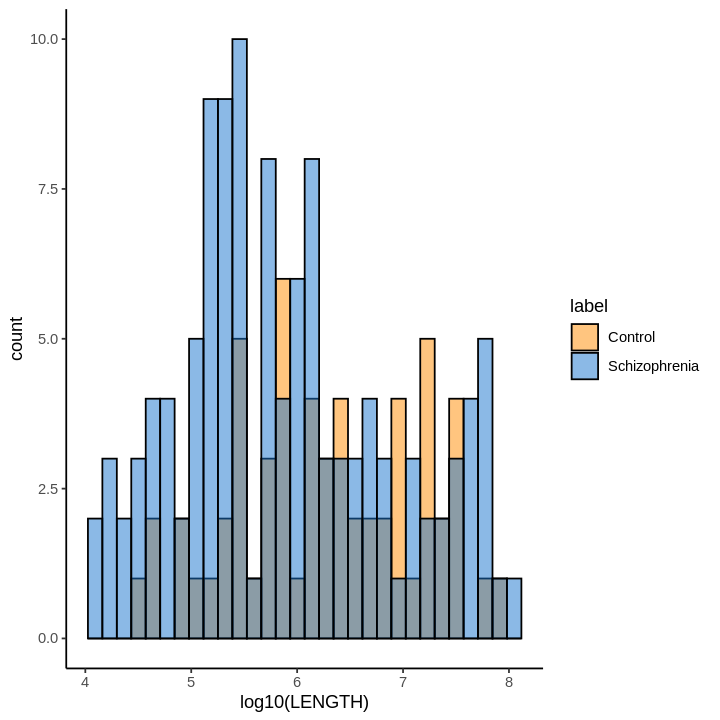

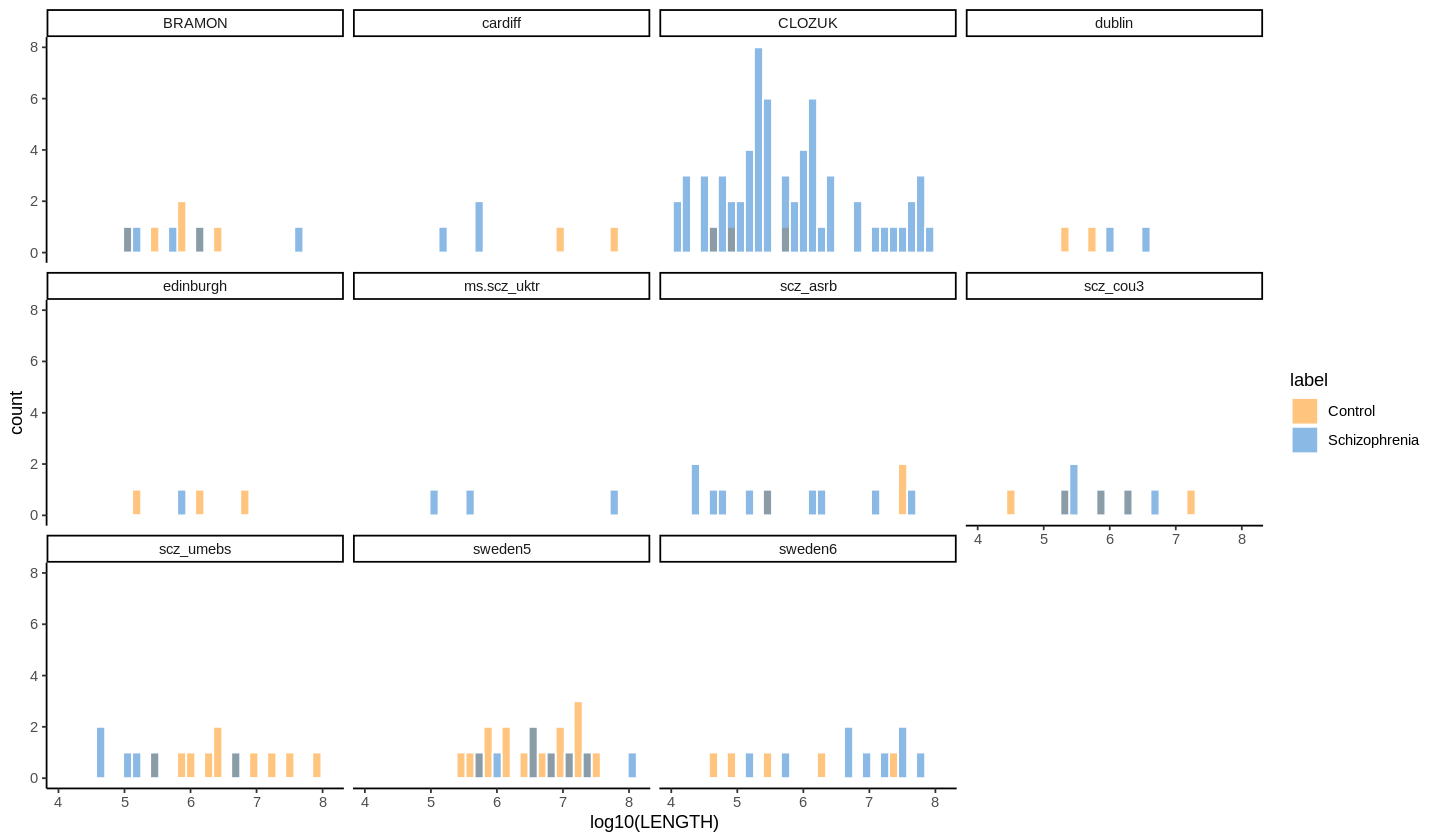

In [11]:
df_mosaic_$batch[(df_mosaic_$batch =="scz_clm2") | (df_mosaic_$batch == "scz_clo3")] = "CLOZUK"


library(scales)
df_mosaic_$isSCZ = ifelse(df_mosaic_$label == "SCZ", 1,0)


summary(glmer(isSCZ ~ log10(LENGTH) + SEX + (1|batch), family=binomial("logit"), 
              data=df_mosaic_  %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>% summarise(LENGTH = sum(LENGTH)) %>% ungroup()))
length_model = glmer(isSCZ ~ log10(LENGTH) + SEX + (1|batch), family=binomial("logit"), 
              data=df_mosaic_  %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>% summarise(LENGTH = sum(LENGTH)) %>% ungroup())
exp(confint(length_model, level=0.95))

options(repr.plot.width=6, repr.plot.height=6)
p1 = df_mosaic_ %>% group_by(SAMPLE, SEX, batch, isSCZ,label, arrayName) %>% summarise(LENGTH = sum(LENGTH)) %>% ungroup() %>% 
  ggplot(aes(x=log10(LENGTH)))+
  geom_histogram( aes(fill=label), alpha=0.5,position="identity", color="black",bins=30) +
  scale_fill_manual(values=c("darkorange","dodgerblue3"),label=c("Control","Schizophrenia")) + theme_classic() 
p1

options(repr.plot.width=12, repr.plot.height=7)
length_batch = df_mosaic_ %>% group_by(SAMPLE, SEX, batch, isSCZ,label, arrayName) %>% summarise(LENGTH = sum(LENGTH)) %>% ungroup() %>% 
  ggplot(aes(x=log10(LENGTH)))+
  geom_histogram( aes(fill=label, color=label), alpha=0.5,position="identity",bins=30, color="white") +
  scale_fill_manual(values=c("darkorange","dodgerblue3"),label=c("Control","Schizophrenia")) + theme_classic()  + facet_wrap(~batch)

length_batch


### Figure 1F

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: isSCZ ~ CF + SEX + scale(LENGTH) + (1 | batch)
   Data: df_mosaic_ %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>%  
    summarise(CF = mean(CF), LENGTH = sum(LENGTH)) %>% ungroup()

     AIC      BIC   logLik deviance df.resid 
   193.4    209.3    -91.7    183.4      173 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0380 -0.7370  0.2492  0.5624  1.6475 

Random effects:
 Groups Name        Variance Std.Dev.
 batch  (Intercept) 1.193    1.092   
Number of obs: 178, groups:  batch, 11

Fixed effects:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.16819    0.59658   0.282    0.778
CF             0.05255    1.39443   0.038    0.970
SEXM           0.43530    0.39178   1.111    0.267
scale(LENGTH) -0.02347    0.20591  -0.114    0.909

Correlation of Fixed Effects:
            (Intr) CF     SEXM  
CF          -0.62

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.



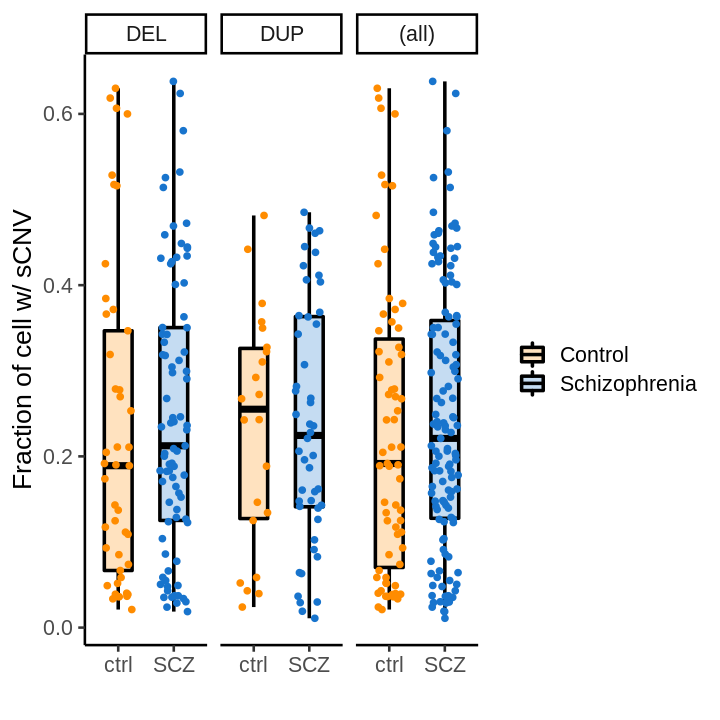

In [12]:
summary(glmer(isSCZ ~ CF + SEX + scale(LENGTH) + (1|batch), family=binomial("logit"), 
              data=df_mosaic_   %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>% summarise(CF = mean(CF), LENGTH=sum(LENGTH)) %>% ungroup()))
cf_model = glmer(isSCZ ~ CF + SEX + scale(LENGTH) + (1|batch), family=binomial("logit"), 
              data=df_mosaic_   %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>% summarise(CF = mean(CF), LENGTH=sum(LENGTH)) %>% ungroup()) 

options(repr.plot.width=6, repr.plot.height=6)
p2 = df_mosaic_ %>% ggplot(aes(x=label, y=CF)) + geom_boxplot(aes(fill=label),color="black",lwd=1, alpha=0.25, width=0.5) +
  geom_jitter(aes(color=label),width=0.25, height=0,show.legend = FALSE) + 
  #scale_y_log10() + 
  labs(x="",y="Fraction of cell w/ sCNV",fill="") + 
  scale_fill_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  scale_color_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  theme_classic(base_size = 16) + facet_grid(cols=vars(RETYPE),margins = TRUE)

p2

### Supplementary Figure 1C

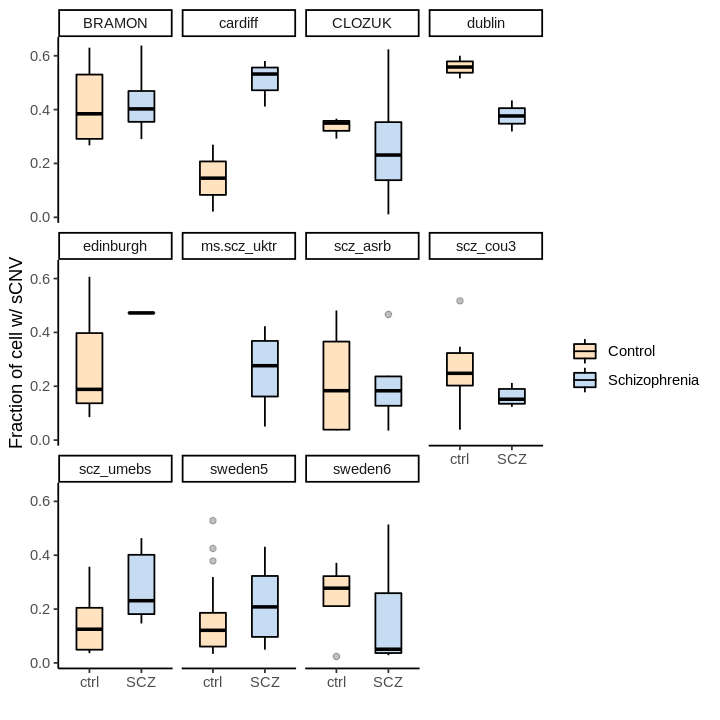

In [13]:
cf_batch = df_mosaic_ %>% ggplot(aes(x=label, y=CF)) + geom_boxplot(aes(fill=label),color="black",lwd=0.5, alpha=0.25, width=0.5)+
  #scale_y_log10() + 
  labs(x="",y="Fraction of cell w/ sCNV",fill="") + 
  scale_fill_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  scale_color_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  theme_classic() + facet_wrap(~batch)

cf_batch

### Figure 1G

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: isSCZ ~ ngenes + SEX + scale(LENGTH) + (1 | batch)
   Data: df_mosaic_ %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>%  
    summarise(ngenes = sum(number_genes), LENGTH = sum(LENGTH),  
        n_bp = ngenes/LENGTH) %>% ungroup()

     AIC      BIC   logLik deviance df.resid 
   191.2    207.1    -90.6    181.2      173 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2020 -0.6788  0.2396  0.5488  1.8532 

Random effects:
 Groups Name        Variance Std.Dev.
 batch  (Intercept) 1.227    1.108   
Number of obs: 178, groups:  batch, 11

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.469792   0.506593   0.927    0.354
ngenes        -0.005326   0.003544  -1.503    0.133
SEXM           0.413745   0.393618   1.051    0.293
scale(LENGTH)  0.455841   0.375179   1.215    0.224

Correlation of Fixed Effec

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'SAMPLE', 'SEX', 'batch', 'isSCZ'. You can override using the `.groups` argument.



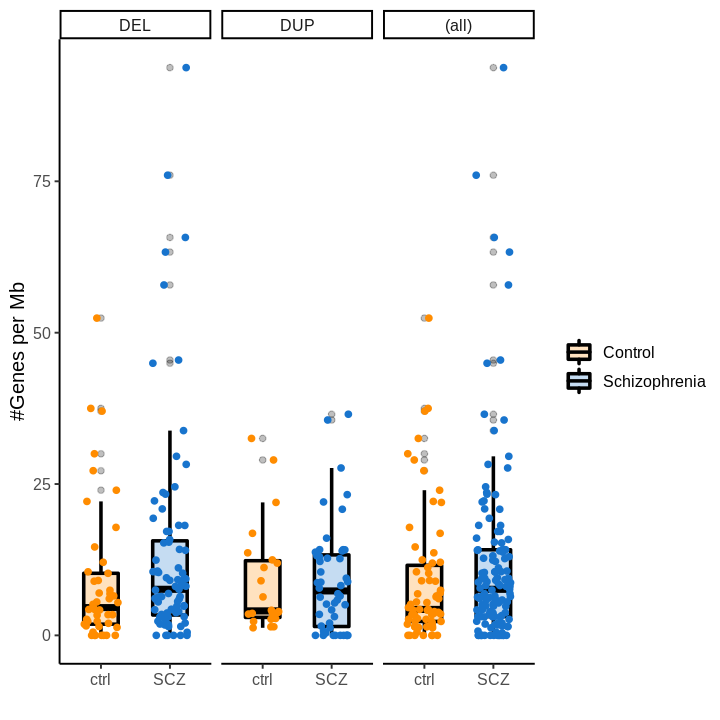

In [14]:

summary(glmer(isSCZ ~ngenes + SEX + scale(LENGTH) + (1|batch), family=binomial("logit"), 
              data=df_mosaic_  %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>% summarise(ngenes= sum(number_genes), LENGTH=sum(LENGTH), n_bp = ngenes/LENGTH )%>% ungroup()))

num_genes_model = glmer(isSCZ ~ngenes + SEX + scale(LENGTH) + (1|batch), family=binomial("logit"), 
              data=df_mosaic_  %>% group_by(SAMPLE, SEX, batch, isSCZ, arrayName) %>% summarise(ngenes= sum(number_genes), LENGTH=sum(LENGTH), n_bp = ngenes/LENGTH )%>% ungroup())

p3 = df_mosaic_ %>% mutate(genes_per_mb = number_genes/LENGTH*1e6) %>% ggplot(aes(x=label, y=genes_per_mb)) + geom_boxplot(aes(fill=label),color="black",lwd=1, alpha=0.25, width=0.5) +
  geom_jitter(aes(color=label),width=0.25, height=0,show.legend = FALSE) + 
  #scale_y_log10() + 
  labs(x="",y="#Genes per Mb",fill="") + 
  scale_fill_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  scale_color_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  theme_classic(base_size = 12) + facet_grid(cols=vars(RETYPE),margins = TRUE)

p3


### Supplementary Figure 1D

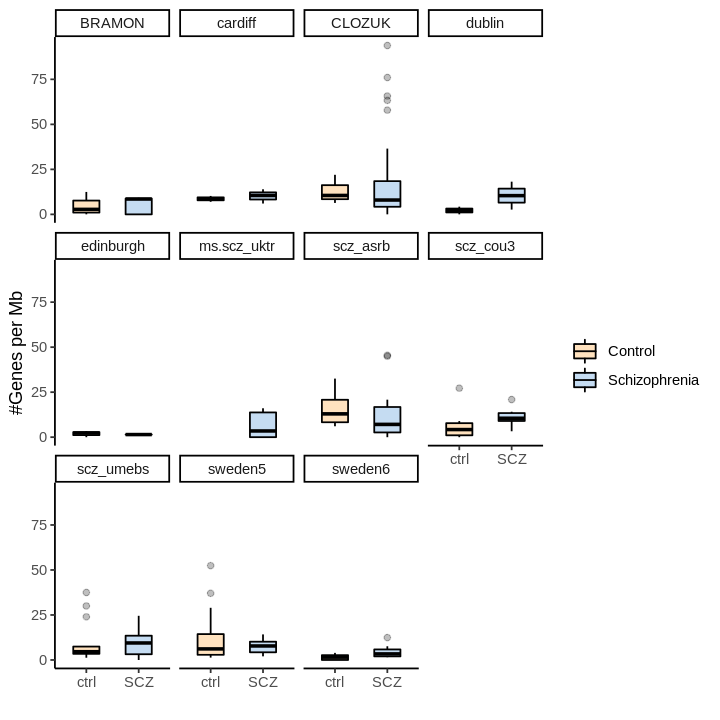

In [15]:

genes_batch = df_mosaic_ %>% mutate(genes_per_mb = (number_genes/LENGTH*10^6)) %>% ggplot(aes(x=label, y=genes_per_mb)) + geom_boxplot(aes(fill=label),color="black",lwd=0.5, alpha=0.25, width=0.5) +
  #scale_y_log10() + 
  labs(x="",y="#Genes per Mb",fill="") + 
  scale_fill_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  scale_color_manual(values=c("darkorange","dodgerblue3"),labels=c("Control","Schizophrenia")) +
  theme_classic() + facet_wrap(.~batch)

genes_batch

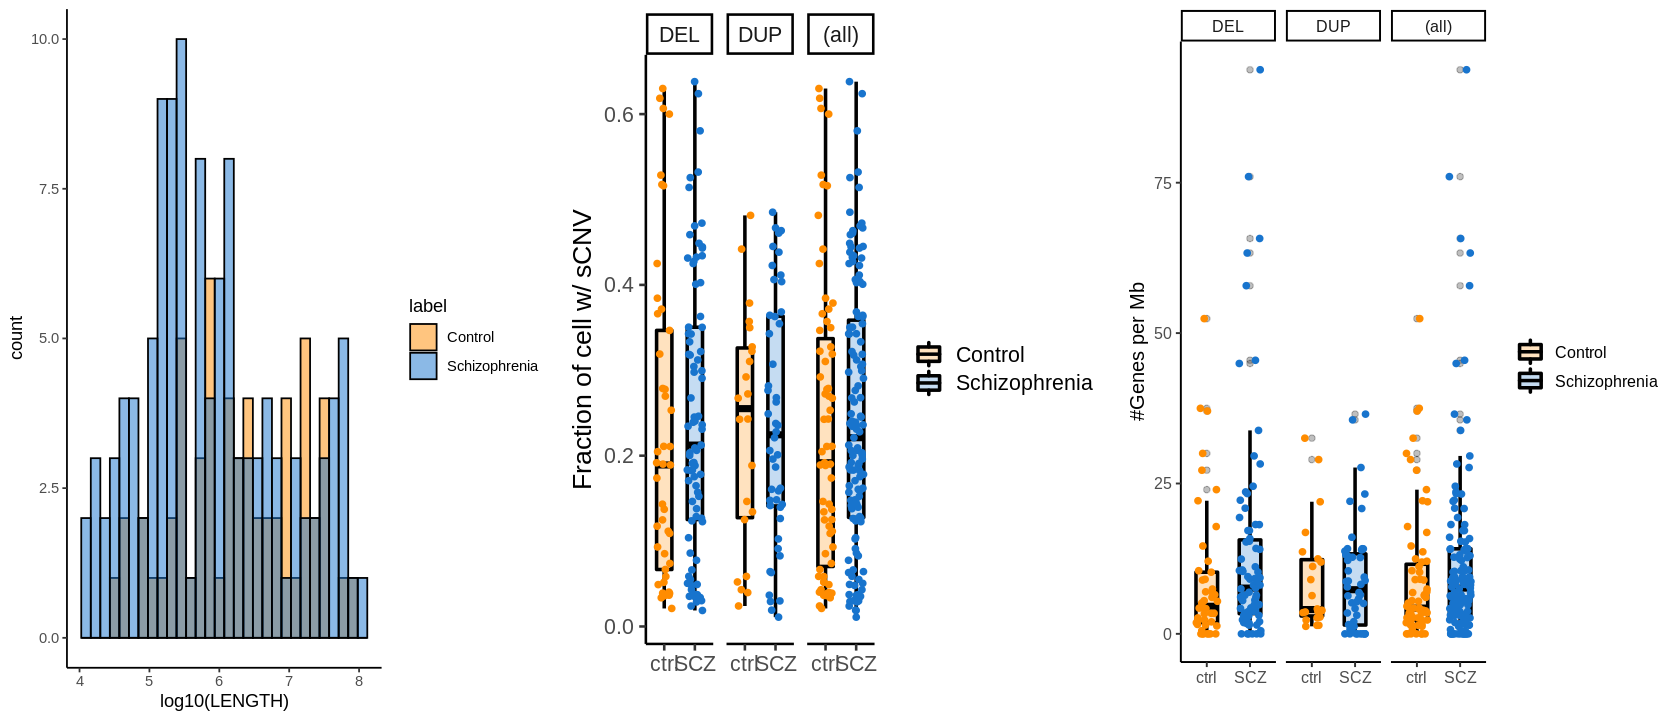

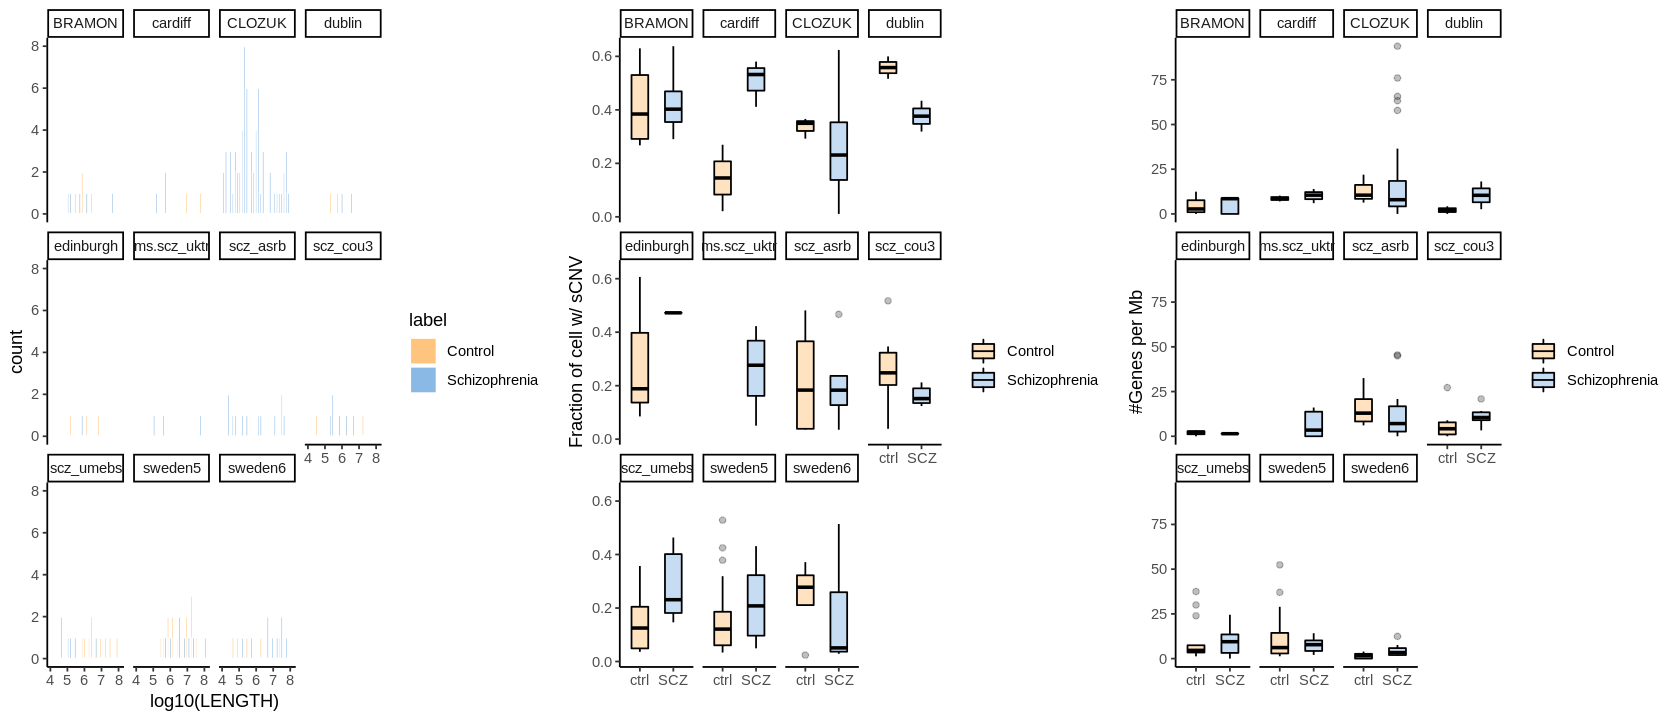

In [16]:
## plotting length, Cf, and #genes
options(repr.plot.width=14, repr.plot.height=6)
ggarrange(p1,p2,p3, ncol=3, nrow=1)

ggarrange(length_batch,cf_batch,genes_batch,ncol=3,nrow=1)


In [19]:
## Perfming F-test for CNV gene-set enrichment

ftest <- function(df){
  M0 = glm(diagnosis ~ tot_muts + tot_LENGTH, data= df_sample, family="binomial")
  M1 = glm(diagnosis ~ tot_muts + tot_LENGTH + n_genes, data = df_sample, family="binomial")
  print(summary(M1))
  res = anova(M0, M1)
  p_value = 1 - pchisq(res$Deviance,df=1)
  print(p_value[2])
  return(p_value[2])
  
}





## Number of genes
df_sample <- df_mosaic_ %>%  filter(CF > 0) %>% group_by(SAMPLE, label, SEX) %>% 
  summarise(n_genes = sum(number_genes), tot_muts = n(), tot_LENGTH = sum(LENGTH), diagnosis = ifelse(label=="SCZ", yes=1, no =0)) %>% ungroup() %>%
  mutate(tot_LENGTH = (tot_LENGTH - mean(tot_LENGTH))/sd(tot_LENGTH))

ftest(df_sample)

## Brain Expression
df_sample <- df_mosaic_  %>% group_by(SAMPLE, label, SEX) %>% 
  summarise(n_genes = sum(brain_genes), tot_muts = n(), tot_LENGTH = sum(LENGTH), diagnosis = ifelse(label=="SCZ", yes=1, no =0)) %>% ungroup() %>%
  mutate(tot_LENGTH = (tot_LENGTH - mean(tot_LENGTH))/sd(tot_LENGTH))

brain_pval = ftest(df_sample)

## Synaptic genes
df_sample <- df_mosaic_ %>% group_by(SAMPLE, label, SEX) %>% 
  summarise(n_genes = sum(synaptic_genes), tot_muts = n(), tot_LENGTH = sum(LENGTH), diagnosis = ifelse(label=="SCZ", yes=1, no =0)) %>% ungroup() %>%
  mutate(tot_LENGTH = (tot_LENGTH - mean(tot_LENGTH))/sd(tot_LENGTH))

synaptic_pval = ftest(df_sample)

## pLI genes
df_sample <- df_mosaic_  %>% group_by(SAMPLE, label, SEX) %>% 
  summarise(n_genes = sum(high_pLI_genes), tot_muts = n(), tot_LENGTH = sum(LENGTH), diagnosis = ifelse(label=="SCZ", yes=1, no =0)) %>% ungroup() %>%
  mutate(tot_LENGTH = (tot_LENGTH - mean(tot_LENGTH))/sd(tot_LENGTH))

high_pLI_pval= ftest(df_sample)

`summarise()` has grouped output by 'SAMPLE', 'label', 'SEX'. You can override using the `.groups` argument.




Call:
glm(formula = diagnosis ~ tot_muts + tot_LENGTH + n_genes, family = "binomial", 
    data = df_sample)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5745  -1.4323   0.8732   0.8790   1.4344  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.806914   0.480442   1.680    0.093 .
tot_muts     0.048299   0.310406   0.156    0.876  
tot_LENGTH   0.183945   0.342305   0.537    0.591  
n_genes     -0.003361   0.002865  -1.173    0.241  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 253.42  on 197  degrees of freedom
Residual deviance: 250.87  on 194  degrees of freedom
AIC: 258.87

Number of Fisher Scoring iterations: 4

[1] 0.2331793


[1] 0.2331793

`summarise()` has grouped output by 'SAMPLE', 'label', 'SEX'. You can override using the `.groups` argument.




Call:
glm(formula = diagnosis ~ tot_muts + tot_LENGTH + n_genes, family = "binomial", 
    data = df_sample)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5970  -1.4357   0.8722   0.8778   1.4608  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.820154   0.478139   1.715   0.0863 .
tot_muts     0.054183   0.308413   0.176   0.8605  
tot_LENGTH   0.217267   0.350494   0.620   0.5353  
n_genes     -0.005530   0.004429  -1.249   0.2118  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 253.42  on 197  degrees of freedom
Residual deviance: 250.70  on 194  degrees of freedom
AIC: 258.7

Number of Fisher Scoring iterations: 4

[1] 0.206263


`summarise()` has grouped output by 'SAMPLE', 'label', 'SEX'. You can override using the `.groups` argument.




Call:
glm(formula = diagnosis ~ tot_muts + tot_LENGTH + n_genes, family = "binomial", 
    data = df_sample)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5650  -1.4131   0.8703   0.8803   1.5416  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept)  0.79890    0.45517   1.755   0.0792 .
tot_muts     0.04718    0.30766   0.153   0.8781  
tot_LENGTH   0.15033    0.28192   0.533   0.5939  
n_genes     -0.03175    0.02264  -1.402   0.1609  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 253.42  on 197  degrees of freedom
Residual deviance: 250.24  on 194  degrees of freedom
AIC: 258.24

Number of Fisher Scoring iterations: 4

[1] 0.1517914


`summarise()` has grouped output by 'SAMPLE', 'label', 'SEX'. You can override using the `.groups` argument.




Call:
glm(formula = diagnosis ~ tot_muts + tot_LENGTH + n_genes, family = "binomial", 
    data = df_sample)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5528  -1.4419   0.8849   0.8876   1.2929  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.602136   0.473119   1.273    0.203
tot_muts     0.114307   0.311079   0.367    0.713
tot_LENGTH  -0.040041   0.333302  -0.120    0.904
n_genes     -0.006372   0.014223  -0.448    0.654

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 253.42  on 197  degrees of freedom
Residual deviance: 252.09  on 194  degrees of freedom
AIC: 260.09

Number of Fisher Scoring iterations: 4

[1] 0.6541748


### Figure 2B


	Fisher's Exact Test for Count Data

data:  matrix(c(6, n_SCZ - 6, 0, n_CONT), byrow = TRUE, nc = 2)
p-value = 0.03233
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.068827      Inf
sample estimates:
odds ratio 
       Inf 



	Fisher's Exact Test for Count Data

data:  matrix(c(6, n_SCZ - 6, 2, 5e+05), byrow = TRUE, nc = 2)
p-value = 6.579e-09
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   20.90685 1165.83469
sample estimates:
odds ratio 
  117.0802 


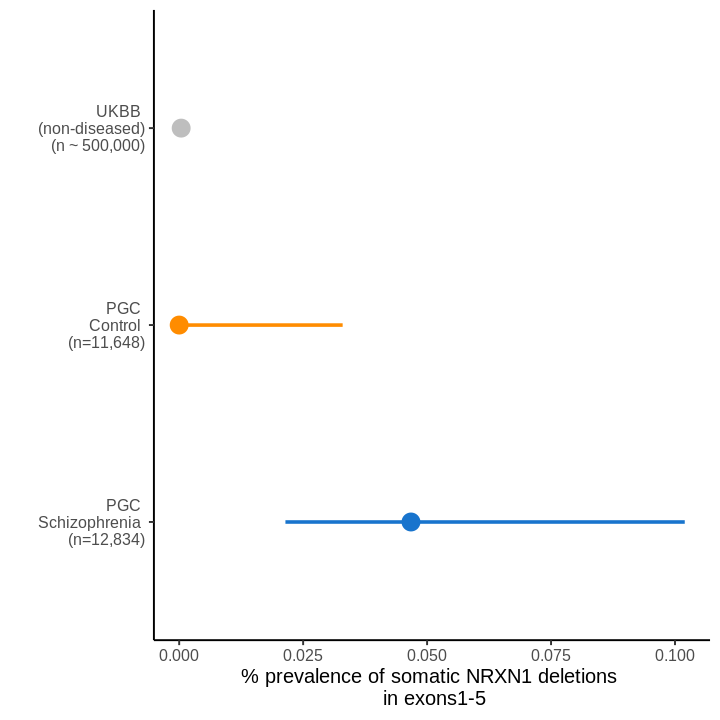

In [18]:
library(Hmisc)

options(repr.plot.width=6, repr.plot.height=6)
nrxn1_df = data.frame(event_count = c(6,0,2), n = c(n_SCZ, n_CONT, 500000), 
                      cohort = factor(c("PGC \n Schizophrenia \n (n=12,834)", 
                                        "PGC \n Control \n (n=11,648)",
                                        "UKBB \n (non-diseased)\n (n ~ 500,000)"), 
                                      levels= c("PGC \n Schizophrenia \n (n=12,834)", 
                                        "PGC \n Control \n (n=11,648)",
                                        "UKBB \n (non-diseased)\n (n ~ 500,000)")))

fisher.test(matrix(c(6,n_SCZ-6,0,n_CONT),byrow=TRUE, nc=2))
fisher.test(matrix(c(6,n_SCZ-6,2,500000),byrow=TRUE, nc=2))

nrxn1_df = nrxn1_df %>%  mutate(burden = event_count/n, 
                                ciupper= binconf(event_count, n, method="wilson", return.df=TRUE)$Upper, 
                                cilower = binconf(event_count, n, method="wilson", return.df=TRUE)$Lower,
                                )

nrxn1_df %>% ggplot(aes(y=cohort,x=burden*100)) + geom_pointrange(aes(xmin=cilower*100, xmax=100*ciupper, color=cohort), lwd=1, show.legend=FALSE) + theme_classic(base_size=12) + labs(x="% prevalence of somatic NRXN1 deletions \n in exons1-5",y="") + scale_color_manual(values=c("dodgerblue3","darkorange","gray"))

### Figure 2D

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, ta

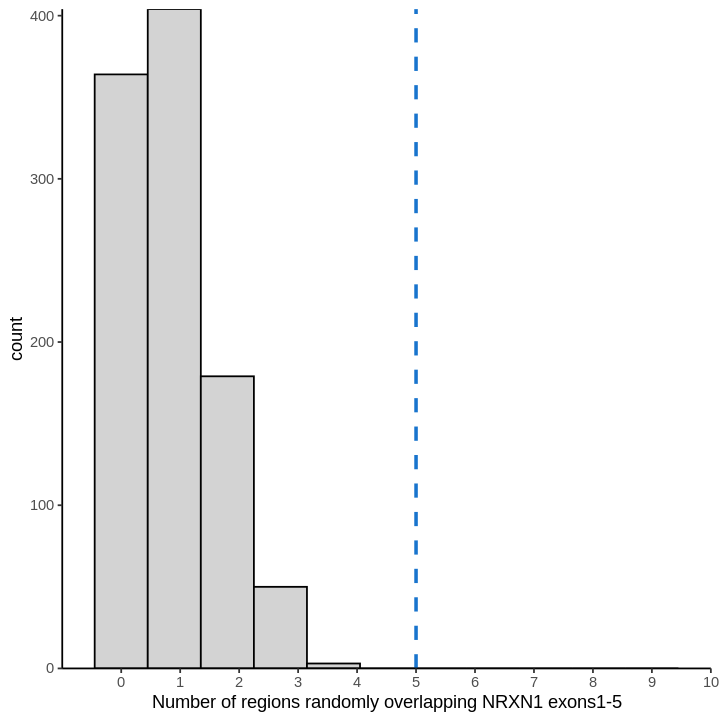

In [19]:

library(regioneR)
nrxn1_calls = df_mosaic_ %>% filter(label=="SCZ",GENES=="NRXN1") %>% dplyr::select(c(CHROM, BEG_GRCh37, END_GRCh37))

nrxn1_universe = GRanges(seqnames=c("chr2"),IRanges(start=49145641,end=52259270))
nrxn1_exon15= GRanges(seqnames=c("chr2"), IRanges(start=51148610,end=51259691))

nrxn1_calls$CHROM = paste0("chr",nrxn1_calls$CHROM) 
nrxn1_RS = toGRanges(nrxn1_calls %>% data.frame())
seqlevels(nrxn1_universe) = seqlevels(nrxn1_exon15) = seqlevels(nrxn1_RS) = "chr2"

mask_region = data.frame("chr2",c(1,52259271),c(49145640,250000000))

# pt <- permTest(A=nrxn1_RS, B=nrxn1_exon15,randomize.function=randomizeRegions, evaluate.function=numOverlaps,
#                universe=nrxn1_universe,mask=mask_region,ntimes=1000)
# plot(pt)

niter=1000
n_overlaps = rep(0,niter)
for(i in 1:niter){
  random_regions = randomizeRegions(A=nrxn1_RS,mask=mask_region,genome=nrxn1_universe, per.chromsome=TRUE)
  n_overlaps[i] = numOverlaps(random_regions, nrxn1_exon15)
  
}
observed_olaps = 5
p_value = sum(n_overlaps > observed_olaps)/niter

data.frame(n_overlaps = n_overlaps) %>% ggplot(aes(x=n_overlaps)) + geom_histogram(fill="lightgray",color="black", binwidth=0.9) +
  geom_vline(xintercept=observed_olaps,color = "dodgerblue3",size=1,linetype=2) + theme_classic() +
  scale_x_continuous(breaks=seq.int(0,10), limits=c(-1,10),expand=c(0,0)) +
  scale_y_continuous(expand = c(0,0) ) + labs(x = "Number of regions randomly overlapping NRXN1 exons1-5")

### Figure 3C,D


	Fisher's Exact Test for Count Data

data:  matrix(c(6, n_SCZ - 6, 0, n_CONT), byrow = TRUE, nc = 2)
p-value = 0.03233
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.068827      Inf
sample estimates:
odds ratio 
       Inf 



	Fisher's Exact Test for Count Data

data:  matrix(c(6, n_SCZ - 6, 0, n_CONT), byrow = TRUE, nc = 2)
p-value = 0.03233
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.068827      Inf
sample estimates:
odds ratio 
       Inf 



	Fisher's Exact Test for Count Data

data:  matrix(c(6, 6357, 0, 6477), byrow = TRUE, nc = 2)
p-value = 0.01479
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.199061      Inf
sample estimates:
odds ratio 
       Inf 



	Fisher's Exact Test for Count Data

data:  matrix(c(6, 7438, 0, 17044), byrow = TRUE, nc = 2)
p-value = 0.000788
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 2.697141      Inf
sample estimates:
odds ratio 
       Inf 


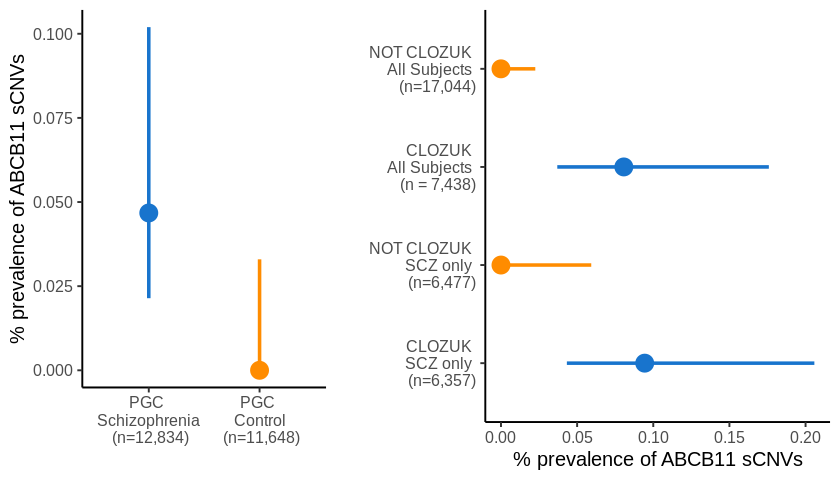

In [20]:
options(repr.plot.width=6, repr.plot.height=6)
abcb11_calls = df_mosaic_ %>% filter(label=="SCZ", GENES=="ABCB11")
abcb11_df = data.frame(event_count = c(6,0), n = c(n_SCZ, n_CONT), 
                      cohort = factor(c("PGC \n Schizophrenia \n (n=12,834)", 
                                        "PGC \n Control \n (n=11,648)"), 
                                      levels= c("PGC \n Schizophrenia \n (n=12,834)", 
                                        "PGC \n Control \n (n=11,648)")))

fisher.test(matrix(c(6,n_SCZ-6,0,n_CONT),byrow=TRUE, nc=2))
fisher.test(matrix(c(6,n_SCZ-6,0,n_CONT),byrow=TRUE, nc=2))

abcb11_df = abcb11_df %>%  mutate(burden = event_count/n, 
                                ciupper= binconf(event_count, n, method="wilson", return.df=TRUE)$Upper, 
                                cilower = binconf(event_count, n, method="wilson", return.df=TRUE)$Lower,
                                )

p1=abcb11_df %>% ggplot(aes(y=cohort,x=burden*100)) + 
    geom_pointrange(aes(xmin=cilower*100, xmax=100*ciupper, color=cohort), lwd=1, show.legend=FALSE) + 
    theme_classic(base_size=12) + labs(x="% prevalence of ABCB11 sCNVs",y="") + 
    scale_color_manual(values=c("dodgerblue3","darkorange")) + coord_flip()

###############################

abcb11_df2 = data.frame(event_count = c(6,0,6,0), n = c(6357,n_SCZ - 6357, 6357+1081,n_SCZ + n_CONT - 6357 - 1081),
                       cohort = factor(c("CLOZUK \n SCZ only \n (n=6,357)",
                                        "NOT CLOZUK \n SCZ only \n (n=6,477)",
                                        "CLOZUK \n All Subjects \n (n = 7,438)",
                                        "NOT CLOZUK \n All Subjects \n (n=17,044)"),
                                      levels=c("CLOZUK \n SCZ only \n (n=6,357)",
                                        "NOT CLOZUK \n SCZ only \n (n=6,477)",
                                        "CLOZUK \n All Subjects \n (n = 7,438)",
                                        "NOT CLOZUK \n All Subjects \n (n=17,044)")))
fisher.test(matrix(c(6,6357,0,6477), byrow=TRUE, nc=2))
fisher.test(matrix(c(6,7438,0,17044), byrow=TRUE, nc=2))

abcb11_df2 = abcb11_df2 %>% mutate(burden = event_count/n, 
                                ciupper= binconf(event_count, n, method="wilson", return.df=TRUE)$Upper, 
                                cilower = binconf(event_count, n, method="wilson", return.df=TRUE)$Lower,
                                )
p2 = abcb11_df2 %>% ggplot(aes(y=cohort, x= burden*100)) +
    geom_pointrange(aes(xmin=cilower*100, xmax=100*ciupper, color=cohort), lwd=1, show.legend=FALSE) + 
    theme_classic(base_size=12) + labs(x="% prevalence of ABCB11 sCNVs",y="") + 
    scale_color_manual(values=c("dodgerblue3","darkorange","dodgerblue3","darkorange"))

options(repr.plot.width=7, repr.plot.height=4)
pn = ggarrange(p1,p2,nrow=1,ncol=2, heights = c(2,0.80), widths = c(1,1.5))
pn


### Figure 4


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  CHROM = col_character(),
  BEG = col_double(),
  END = col_double(),
  sampleInfo = col_character(),
  diagnosis = col_character(),
  TYPE = col_character(),
  RETYPE = col_character(),
  batch = col_character(),
  CYTOBAND = col_character(),
  GENES = col_character(),
  LENGTH = col_double(),
  number_genes = col_double(),
  log_number_genes = col_double(),
  Array = col_character()
)


`summarise()` has grouped output by 'subject', 'batch', 'diagnosis'. You can override using the `.groups` argument.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(LENGTH) ~ isSomatic + (1 | batch)
   Data: df_

REML criterion at convergence: 8608.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0460 -0.8457 -0.0755  0.6344  4.7591 

Random effects:
 Groups   Name        Variance Std.Dev.
 batch    (Intercept) 0.001433 0.03786 
 Residual             0.762876 0.87343 
Number of obs: 3349, groups:  batch, 15

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)       12.64354    0.02213   4.30053  571.21 1.17e-11 ***
isSomaticsomatic   1.55271    0.09247 264.10100   16.79  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
isSomtcsmtc -0.207

Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,1.000000e+00,1.105564e+00
.sigma,2.346270e+00,2.446665e+00
(Intercept),2.893185e+05,3.253834e+05
isSomaticsomatic,3.895177e+00,5.665813e+00


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log(num_genes + 1) ~ isSomatic + scale(LENGTH) + (1 | batch)
   Data: df_

REML criterion at convergence: 8395.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7685 -1.0875 -0.2942  0.6533  3.8452 

Random effects:
 Groups   Name        Variance Std.Dev.
 batch    (Intercept) 0.002804 0.05296 
 Residual             0.714204 0.84511 
Number of obs: 3349, groups:  batch, 15

Fixed effects:
                  Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)      1.005e+00  2.590e-02 7.937e+00  38.806 2.45e-10 ***
isSomaticsomatic 6.096e-01  1.007e-01 3.362e+02   6.053 3.80e-09 ***
scale(LENGTH)    3.366e-01  1.613e-02 3.345e+03  20.859  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) isSmtc
isSomtcsmtc -0.229       
scl(LENGTH)  0.059 -0.407

Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,1.012341,1.111029
.sigma,2.281865,2.376220
(Intercept),2.572789,2.872836
isSomaticsomatic,1.508906,2.236447
scale(LENGTH),1.356548,1.445108


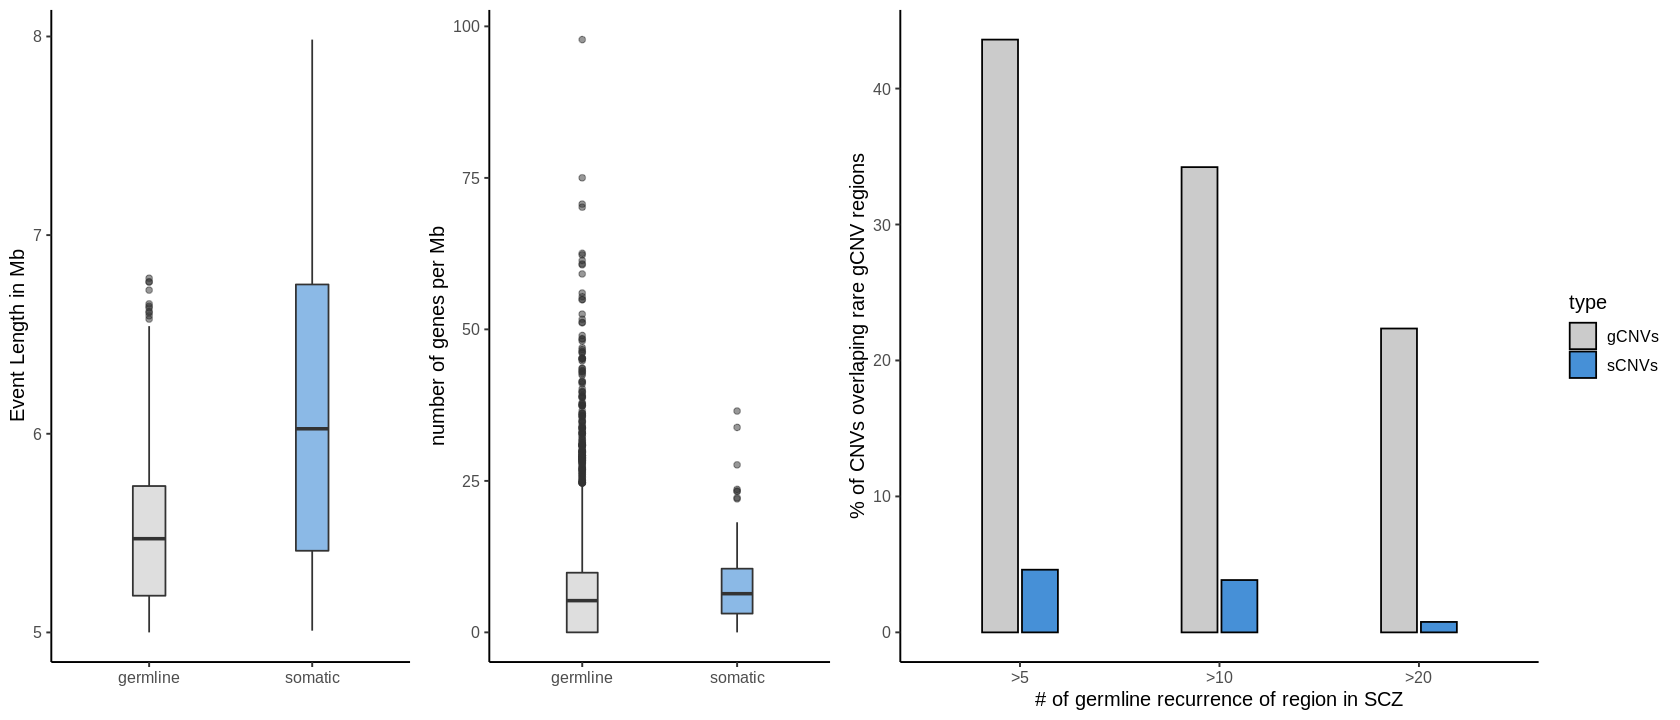

In [21]:
## Overlap plot of the sCNVs in SCZ with rare gCNVs present in >5 individuals from PGC phase2. 
## Percentage values were generated using the results from running `PGC_gCNV_overlap_analysis` notebook. 

df = data.frame(percentage = c(43.60, 4.61,34.22, 3.85, 22.35,0.769), type= c("gCNVs","sCNVs","gCNVs","sCNVs","gCNVs","sCNVs"), recurrence_germline = factor(c(">5",">5",">10",">10",">20",">20"), levels=c(">5",">10",">20")))
p3 = df %>% ggplot(aes(x=recurrence_germline, y=percentage)) + 
  geom_bar(stat="identity",aes(fill=type), position=position_dodge2(), width=0.4, alpha=0.8, color="black") + 
  scale_fill_manual(values=c("gray","dodgerblue3"), labels=c("gCNVs","sCNVs")) + theme_classic(base_size=12) +
  labs(x="# of germline recurrence of region in SCZ", y="% of CNVs overlaping rare gCNV regions")
#p3

df_mosaic_0 = df_mosaic_ %>% filter(label=="SCZ" & LENGTH > 1e5) #%>% filter(CF > 0.20)

df_germline <- read_csv("../data/metadata/PGC_SCZ_anno_callset_cnv.csv")
df_germline <- df_germline %>% mutate(batch = str_replace(.$batch,"_eur",replacement="")) %>% filter(CHROM != "X") %>% 
  mutate(batch = str_replace(.$batch,"scz_swe6","sweden6")) %>% mutate(batch = str_replace(.$batch,"scz_swe5","sweden5")) %>%
  mutate(batch = str_replace(.$batch, "fam_scz_uktr","ms.scz_uktr")) %>% filter(LENGTH > 1e5) %>% filter(diagnosis=="SCZ") %>% filter(!(batch %in% c("scz_denm","scz_umes")))

df_germline <- df_germline %>% filter(diagnosis == "SCZ" & LENGTH > 1e5)

df_ = data.frame(diagnosis=c(df_mosaic_0$label, df_germline$diagnosis), 
               batch = c(df_mosaic_0$batch, df_germline$batch),
               LENGTH = c(df_mosaic_0$LENGTH, df_germline$LENGTH),
               num_genes = c(df_mosaic_0$number_genes, df_germline$number_genes),
               subject = c(df_mosaic_0$SAMPLE, df_germline$sampleInfo),
               isSomatic = c(rep("somatic",nrow(df_mosaic_0)),rep("germline",nrow(df_germline))))

df_ = df_ %>% group_by(subject,batch,diagnosis, isSomatic) %>% summarise(num_genes=sum(num_genes),LENGTH = sum(LENGTH)) %>% ungroup()

p1 = df_ %>% ggplot(aes(x=isSomatic,y = log10(LENGTH))) + geom_boxplot(aes(fill=isSomatic), alpha = 0.5,show.legend = FALSE, width=0.2) + scale_fill_manual(values=c("gray","dodgerblue3"),labels=c("Control","Schizophrenia")) + theme_classic(base_size = 12) + labs(x="",y="Event Length in Mb", fill="")  # facet_wrap(vars(batch))



#summary(glmer(is_som ~ scale(LENGTH) + (1|batch), data=df_ %>% mutate(is_som = ifelse(isSomatic == "somatic", 1,0)),  family=binomial("logit")))

mod2 = lmer(log(LENGTH) ~ isSomatic  +  (1|batch) , data=df_)
summary(mod2)
exp(confint(mod2))


p2 = df_ %>% mutate(genes_per_mb = num_genes/LENGTH*1e6) %>% ggplot(aes(x=isSomatic,y =genes_per_mb)) + geom_boxplot(aes(fill=isSomatic), alpha = 0.5,show.legend = FALSE, width=0.2) + scale_fill_manual(values=c("gray","dodgerblue3"),labels=c("Control","Schizophrenia")) + theme_classic(base_size = 12) + labs(x="",y="number of genes per Mb", fill="")  # facet_wrap(vars(batch))

mod2 = lmer(log(num_genes + 1) ~ isSomatic + scale(LENGTH) +  (1|batch) , data=df_)
summary(mod2)
exp(confint(mod2))
#summary(glmer(is_som ~ num_genes + scale(LENGTH) + (1|batch), data=df_ %>% mutate(is_som=ifelse(isSomatic == "somatic",1,0)),  family=binomial("logit")))

options(repr.plot.width=14, repr.plot.height=6)
ggarrange(p1,p2,p3, ncol=3,widths=c(1,1,2))


In [25]:
abcb11_calls = df_mosaic_ %>% filter(label=="SCZ", GENES=="ABCB11") %>% dplyr::select(c(CHROM, BEG_GRCh37, END_GRCh37, RETYPE))
write.table(abcb11_calls,file="abcb11_scnv.bed",row.names=FALSE,col.names=FALSE,quote=FALSE)